# **CIS 545 Data Security and Privacy**

# Final Project

## Group 4

- Grover Susanibar
- Jasleen Chahal
- Manasi Kshirsagar
- Sayali Agalave
- Spencer Scott

# 0. Import Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import io
import pickle
from tqdm.notebook import trange, tqdm
import os
import shutil
import hashlib

# 1. Get Data

In [ ]:
url='https://drive.google.com/file/d/1YOGMimRE9t5GKw2BilwBrf83BsRiU8ji/view?usp=share_link'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]

response = requests.get(url)
response.raise_for_status()
location = np.load(io.BytesIO(response.content), allow_pickle=True)

In [ ]:
X = location['x'][:, :].astype(np.float64)
Y = location['y'][:].astype(np.int32)-1
feat_x = pd.DataFrame(X)
col_names = {i:'visited_loc_{}'.format(i) for i in range(feat_x.shape[1])}
feat_x = feat_x.rename(columns=col_names)
feat_y = pd.DataFrame(Y, columns=['geosocial_type'])
df = pd.concat([feat_x, feat_y], axis=1)
print(df.shape)
df.head()

(5010, 447)


,visited_loc_0,visited_loc_1,visited_loc_2,visited_loc_3,visited_loc_4,visited_loc_5,visited_loc_6,visited_loc_7,visited_loc_8,visited_loc_9,...,visited_loc_437,visited_loc_438,visited_loc_439,visited_loc_440,visited_loc_441,visited_loc_442,visited_loc_443,visited_loc_444,visited_loc_445,geosocial_type
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,12
1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,10
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,7


# 2. Feature Analysis

## 2.1 Geosocial type distribution

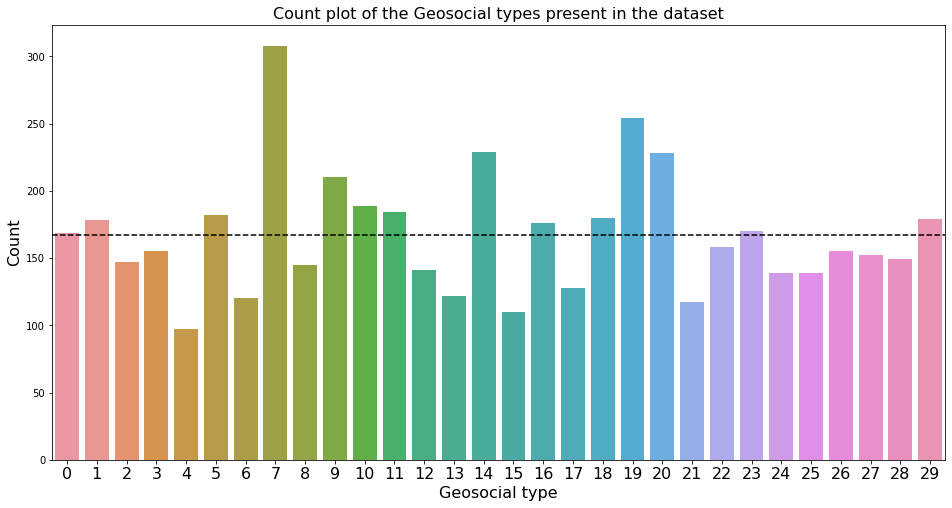

In [ ]:
plt.figure(figsize=(16,8))
cp = sns.countplot(x='geosocial_type', data = df)
cp.set_xticklabels(cp.get_xmajorticklabels(), fontsize = 16, rotation=0)
plt.title('Count plot of the Geosocial types present in the dataset', fontsize = 16)
plt.xlabel('Geosocial type', fontsize = 16)
plt.ylabel('Count', fontsize = 16)
plt.axhline(y=df.geosocial_type.value_counts().mean(), color='k', linestyle='--')
plt.show()

In [ ]:
round(df.geosocial_type.value_counts(normalize=True).sort_values()*100.0,2)

4     1.94
15    2.20
21    2.34
6     2.40
13    2.44
17    2.55
25    2.77
24    2.77
12    2.81
8     2.89
2     2.93
28    2.97
27    3.03
3     3.09
26    3.09
22    3.15
0     3.37
23    3.39
16    3.51
1     3.55
29    3.57
18    3.59
5     3.63
11    3.67
10    3.77
9     4.19
20    4.55
14    4.57
19    5.07
7     6.15
Name: geosocial_type, dtype: float64

## 2.2 Feature correlation

In [ ]:
df_corr = pd.DataFrame(df.corr().unstack().sort_values(kind="quicksort", ascending=False).reset_index())
df_corr = df_corr[df_corr['level_0'] < df_corr['level_1']]
df_corr = df_corr.rename(columns={'level_0':'feature 1','level_1':'feature 2',0:'corr'})
df_corr

,feature 1,feature 2,corr
447,visited_loc_115,visited_loc_175,0.981270
450,visited_loc_14,visited_loc_330,0.961447
451,visited_loc_153,visited_loc_64,0.955386
454,visited_loc_24,visited_loc_410,0.872388
456,visited_loc_131,visited_loc_3,0.851437
...,...,...,...
199800,geosocial_type,visited_loc_294,-0.249256
199802,geosocial_type,visited_loc_163,-0.264968
199804,geosocial_type,visited_loc_1,-0.265653
199805,geosocial_type,visited_loc_26,-0.273924


In [ ]:
df_corr[df_corr['feature 1'] != 'geosocial_type']

,feature 1,feature 2,corr
447,visited_loc_115,visited_loc_175,0.981270
450,visited_loc_14,visited_loc_330,0.961447
451,visited_loc_153,visited_loc_64,0.955386
454,visited_loc_24,visited_loc_410,0.872388
456,visited_loc_131,visited_loc_3,0.851437
...,...,...,...
199709,visited_loc_388,visited_loc_73,-0.116263
199712,visited_loc_35,visited_loc_73,-0.117116
199715,visited_loc_350,visited_loc_39,-0.118743
199744,visited_loc_125,visited_loc_39,-0.145237


In [ ]:
df_corr[(df_corr['corr'] > 0.8) | (df_corr['corr'] < -0.8)]

,feature 1,feature 2,corr
447,visited_loc_115,visited_loc_175,0.981270
450,visited_loc_14,visited_loc_330,0.961447
451,visited_loc_153,visited_loc_64,0.955386
454,visited_loc_24,visited_loc_410,0.872388
456,visited_loc_131,visited_loc_3,0.851437
457,visited_loc_198,visited_loc_33,0.831842


In [ ]:
df_corr[df_corr['feature 1'] == 'geosocial_type']

,feature 1,feature 2,corr
1473,geosocial_type,visited_loc_307,0.232583
2397,geosocial_type,visited_loc_413,0.175107
3075,geosocial_type,visited_loc_125,0.156229
3089,geosocial_type,visited_loc_285,0.155903
3543,geosocial_type,visited_loc_217,0.146813
...,...,...,...
199800,geosocial_type,visited_loc_294,-0.249256
199802,geosocial_type,visited_loc_163,-0.264968
199804,geosocial_type,visited_loc_1,-0.265653
199805,geosocial_type,visited_loc_26,-0.273924


## 2.3 Feature analysis

In [ ]:
df.describe().round(2)

,visited_loc_0,visited_loc_1,visited_loc_2,visited_loc_3,visited_loc_4,visited_loc_5,visited_loc_6,visited_loc_7,visited_loc_8,visited_loc_9,...,visited_loc_437,visited_loc_438,visited_loc_439,visited_loc_440,visited_loc_441,visited_loc_442,visited_loc_443,visited_loc_444,visited_loc_445,geosocial_type
count,5010.00,5010.00,5010.00,5010.00,5010.00,5010.00,5010.00,5010.00,5010.00,5010.00,...,5010.00,5010.00,5010.00,5010.00,5010.00,5010.00,5010.00,5010.00,5010.00,5010.00
mean,0.06,0.18,0.05,0.54,0.09,0.11,0.03,0.06,0.16,0.06,...,0.05,0.04,0.05,0.06,0.05,0.21,0.07,0.12,0.06,14.37
std,0.23,0.38,0.21,0.50,0.29,0.31,0.17,0.23,0.37,0.25,...,0.22,0.20,0.22,0.24,0.21,0.40,0.25,0.33,0.23,8.51
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7.00
50%,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,14.00
75%,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,21.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,29.00


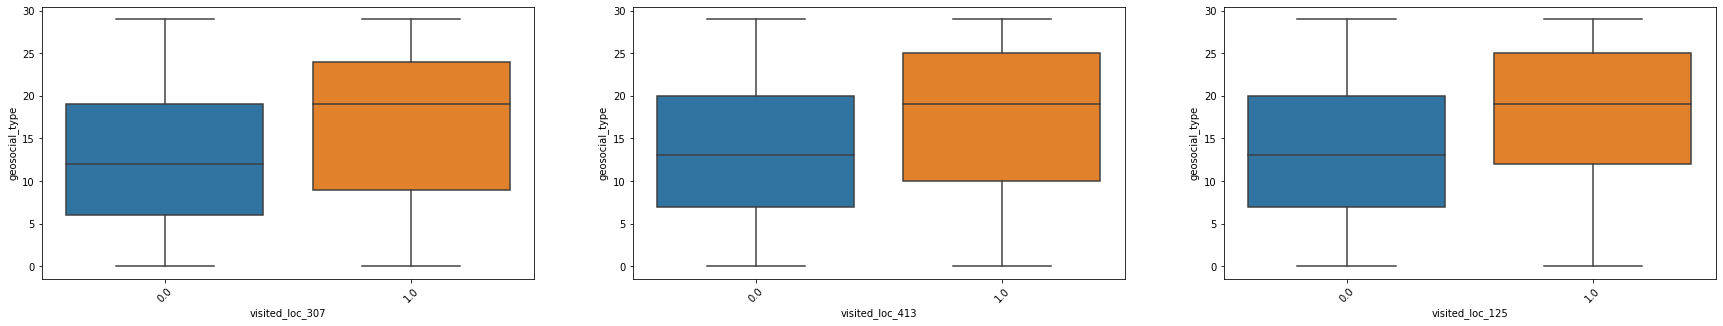

In [ ]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(30, 5))
features_interes = ['visited_loc_307', 'visited_loc_413', 'visited_loc_125']
for col in features_interes:
    i = features_interes.index(col)
    bp = sns.boxplot(x=col, y='geosocial_type', data=df, ax=ax[i])
    bp.set_xticklabels(bp.get_xticklabels(),rotation=45)

## 2.4 Data Augmentation

In [ ]:
!pip install smote-variants --q

     |████████████████████████████████| 407 kB 5.0 MB/s 
     |████████████████████████████████| 64 kB 3.0 MB/s 


In [ ]:
import smote_variants as sv
oversampler= sv.MulticlassOversampling(oversampler='distance_SMOTE', oversampler_params={'random_state': 5, 'proportion': 5})

In [ ]:
## Apply SMOTE to deal with the imbalanced data and increase the samples from the minority classe
X_samp, y_samp= oversampler.sample(X, Y)

In [ ]:
## Shuffle data
X_samp, y_samp = shuffle(X_samp, y_samp, random_state=0)

In [ ]:
## After applying SMOT some variables have decimal values, but in the original dataset, variables are 0 or 1. Then we have to round variables.
X_samp = pd.DataFrame(X_samp).applymap(lambda x: round(x)).to_numpy()

In [ ]:
X_samp.shape

(9215, 446)

In [ ]:
round(pd.DataFrame(y_samp).value_counts(normalize=True).sort_values()*100.0,2)

21    3.33
3     3.33
4     3.33
5     3.33
6     3.33
8     3.33
10    3.33
11    3.33
12    3.33
13    3.33
1     3.33
16    3.33
15    3.33
18    3.33
29    3.33
22    3.33
23    3.33
24    3.33
25    3.33
26    3.33
27    3.33
28    3.33
17    3.33
0     3.33
2     3.33
14    3.34
19    3.34
20    3.34
9     3.34
7     3.34
dtype: float64

- We can see that after applying SMOTE, the size of the dataset increased from 5’010 to 9’215 records. 
- Additionally, now all the classes are balanced.

# 3. Train Model with all data

## 3.1 Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [ ]:
## Hyperarameters tu be tunned
parameters = {
    'max_depth': [3,4,5,6],
    'n_estimators': [200,500,1000],
    'learning_rate': [0.1, 0.01, 0.05],
    'colsample_bytree': [0.2, 0.7],
    'min_child_weight': [1,5,15],
    'gamma': [0,1,2]
}

In [ ]:
## ¡¡ This may take like 2 hours to finish !! We ran this cell and best hyperparameters obtained are used in the model training. Don't need to run again this cell! Uncomment if want to run again.

# model_xgb= XGBClassifier(objective ='multi:softmax', n_jobs=-1, tree_method='gpu_hist')
# gs = RandomizedSearchCV(model_xgb, param_distributions=parameters, n_iter=12, cv=3, scoring="accuracy", n_jobs=-1, random_state=42, verbose=1)
# gs.fit(X_samp, y_samp, verbose=1)
# gs.best_params_

## 3.2 Cross Validation

In [ ]:
import xgboost as xgb
from xgboost import cv
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_val_score

In [ ]:
## As we are using cross validaiton with k=5, it may take some time to run this cell (like 5-10 minutes)
estimator= XGBClassifier(colsample_bytree = 0.2,
                        learning_rate = 0.1,
                        max_depth = 4,
                        min_child_weight = 3, 
                        n_estimators = 200,
                        objective ='multi:softmax',
                        reg_lambda = 0.8,
                        num_class= 30)
cv = cross_val_score(estimator, X=X_samp, y=y_samp, scoring="accuracy", cv=5)

In [ ]:
print(f'Scores for each fold are: {cv}')
print(f'Average score: {"{:.2f}".format(cv.mean())}')

Scores for each fold are: [0.87194791 0.89582203 0.8730331  0.88334238 0.86163863]
Average score: 0.88


- We can see that XGB model got an average accuracy of 88% using cross validation

In [ ]:
## save cross validation model
pickle.dump(cv, open('location_model_cv.pkl', "wb"))

## 3.3 Train model using all data

In [ ]:
model_all = XGBClassifier(colsample_bytree = 0.2,
                        learning_rate = 0.1,
                        max_depth = 4,
                        min_child_weight = 3, 
                        n_estimators = 200,
                        objective ='multi:softmax',
                        reg_lambda = 0.8,
                        num_class= 30)
model_all.fit(X_samp, y_samp)

XGBClassifier(colsample_bytree=0.2, max_depth=4, min_child_weight=3,
              n_estimators=200, num_class=30, objective='multi:softprob',
              reg_lambda=0.8)

In [ ]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
cm = confusion_matrix(y_samp, model_all.predict(X_samp))
df_cm = pd.DataFrame(data=cm, columns=sorted(df.geosocial_type.unique()), index=sorted(df.geosocial_type.unique()))

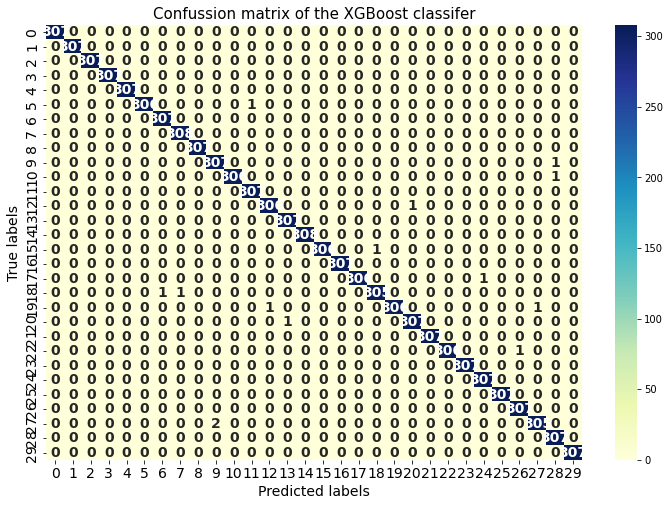

In [ ]:
plt.figure(figsize=(12,8))
sns_hm = sns.heatmap(data=df_cm, cmap='YlGnBu', annot=True, annot_kws={"fontsize":14, 'fontweight':'bold'}, fmt='g')
sns_hm.set_xticklabels(sns_hm.get_xmajorticklabels(), fontsize = 14)
sns_hm.set_yticklabels(sns_hm.get_ymajorticklabels(), fontsize = 14)
plt.title('Confussion matrix of the XGBoost classifer', fontsize=15)
plt.xlabel('Predicted labels', fontsize = 14)
plt.ylabel('True labels', fontsize = 14)
plt.show()

# 4. MIAShield

In [ ]:
def define_model():
    model= XGBClassifier(colsample_bytree = 0.2,
                        learning_rate = 0.1,
                        max_depth = 4,
                        min_child_weight = 3, 
                        n_estimators = 200,
                        objective ='multi:softmax',
                        reg_lambda = 0.8,
                        num_class= 30)
    return model

## 4.1 Model Confidence Based Exclusion (MCE)

In [ ]:
# Create list of models
n_models = 5
list_models = []
for i in range(0, n_models):
    list_models.append(define_model())

In [ ]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=n_models)
skf.get_n_splits(X_samp, y_samp)

5

In [ ]:
# Train small models using cross validation to evaluate performance
for ix, (rest_index, fold_index) in enumerate(tqdm(skf.split(X_samp, y_samp))):
    # Get disjoin subset
    x_rest, x_fold = X_samp[rest_index], X_samp[fold_index]
    y_rest, y_fold = y_samp[rest_index], y_samp[fold_index]

    # Cross validation
    estimator= XGBClassifier(colsample_bytree = 0.2,
                        learning_rate = 0.1,
                        max_depth = 4,
                        min_child_weight = 3, 
                        n_estimators = 200,
                        objective ='multi:softmax',
                        reg_lambda = 0.8,
                        num_class= 30)
    score_cv = cross_val_score(estimator, X=x_fold, y=y_fold, scoring="accuracy", cv=5)
    avg_score = score_cv.mean()

    # Train model
    tmp_model = list_models[ix]
    tmp_model.fit(x_fold, y_fold)
    list_models[ix] = tmp_model

    ## save model
    pickle.dump(tmp_model, open('./location_model_cv_{}.pkl'.format(ix), "wb"))
    print('model {} got accuracy {}% in cross validation'.format(ix, round(avg_score*100,2)))

0it [00:00, ?it/s]

model 0 got accuracy 68.85% in cross validation
model 1 got accuracy 70.75% in cross validation
model 2 got accuracy 69.07% in cross validation
model 3 got accuracy 70.16% in cross validation
model 4 got accuracy 70.05% in cross validation


In [ ]:
new_test_point = np.array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0.])

In [ ]:
def oracle1_predict_MCE(location_record, printing = False):
  ''' Implementation of Most Confident Model oracle method '''
  # Get predictions
  preds = [m.predict_proba([location_record])[0] for m in list_models]
  # Get highest prediction
  max_preds = [p[p.argmax(axis=-1)] for p in preds]
  # Get most confident model
  ix_most_condident = max_preds.index(max(max_preds))
  # Exclude most confident model
  preds_after_exclusion = np.array([p for ix, p in enumerate(preds) if ix != ix_most_condident])
  # Get final prediction using remaining models
  final_pred = np.mean(preds_after_exclusion, axis=0).argmax(axis=-1)

  if(printing):
    return 'Class predicted: {}'.format(final_pred)
  else:
    return final_pred

In [ ]:
oracle1_predict_MCE(new_test_point, printing = True)

'Class predicted: 12'

## 4.2 Exact-Signature-Based Exclusion (ESE)

In [ ]:
# Get dictionary of hashing values of location points
dict_data_hash = {}
for ix, (rest_index, fold_index) in enumerate(tqdm(skf.split(X_samp, y_samp))):
  # Get disjoin subset
  x_rest, x_fold = X_samp[rest_index], X_samp[fold_index]
  y_rest, y_fold = y_samp[rest_index], y_samp[fold_index]
  # Apply hash to location points
  for jx, loc_arr in enumerate(x_fold):
    loc_hash = hashlib.sha1(loc_arr).hexdigest()
    dict_data_hash[loc_hash] = ix
len(dict_data_hash)

0it [00:00, ?it/s]

6899

In [ ]:
def oracle2_predict_ESE(location_record, printing = False):
  ''' Implementation of Exact-Signature-Based Exclusion oracle method '''
  # Get predictions
  preds = [m.predict_proba([location_record])[0] for m in list_models]
  # Apply hash to location point
  loc_hash = hashlib.sha1(np.array(location_record)).hexdigest()
  # Check if hash value if in dictionary of hashing values of location points
  if loc_hash in dict_data_hash:
    # Get model that used location point in training
    ix_match = dict_data_hash[loc_hash]
    # Exclude ESE model
    preds = np.array([p for ix, p in enumerate(preds) if ix != ix_match])
    if(printing):
      print('Exact-Signature-Based image found in train dataset!')

  # Get final prediction using remaining models
  final_pred = np.mean(preds, axis=0).argmax(axis=-1)
  if(printing):
    return 'Class predicted: {}'.format(final_pred)
  else:
    return final_pred

In [ ]:
oracle2_predict_ESE(new_test_point, printing = True)

'Class predicted: 12'

## 4.3 Get predictions from both methods

In [ ]:
df_mce = pd.DataFrame([oracle1_predict_MCE(x) for x in tqdm(X_samp)], columns=['MCE prediction'])
df_ese = pd.DataFrame([oracle2_predict_ESE(x) for x in tqdm(X_samp)], columns=['ESE prediction'])

  0%|          | 0/9215 [00:00<?, ?it/s]

  0%|          | 0/9215 [00:00<?, ?it/s]

In [ ]:
df_xsamp = pd.DataFrame(X_samp).rename(columns=col_names)
df_ysamp = pd.DataFrame(y_samp, columns=['geosocial_type'])
df_samp = pd.concat([df_xsamp, df_ysamp, df_mce, df_ese], axis=1)

In [ ]:
df_samp.head(2)

,visited_loc_0,visited_loc_1,visited_loc_2,visited_loc_3,visited_loc_4,visited_loc_5,visited_loc_6,visited_loc_7,visited_loc_8,visited_loc_9,...,visited_loc_439,visited_loc_440,visited_loc_441,visited_loc_442,visited_loc_443,visited_loc_444,visited_loc_445,geosocial_type,MCE prediction,ESE prediction
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,22,22,22
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,8,8,8


In [ ]:
df_samp[df_samp['MCE prediction'] != df_samp['ESE prediction']].head(2)

,visited_loc_0,visited_loc_1,visited_loc_2,visited_loc_3,visited_loc_4,visited_loc_5,visited_loc_6,visited_loc_7,visited_loc_8,visited_loc_9,...,visited_loc_439,visited_loc_440,visited_loc_441,visited_loc_442,visited_loc_443,visited_loc_444,visited_loc_445,geosocial_type,MCE prediction,ESE prediction
144,0,0,0,1,0,0,0,0,0,0,...,1,0,0,1,0,0,0,19,29,19
178,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,8,8,23


# 5. Demo

# 5.1 Same predictions and both correct

In [ ]:
new_test_point = np.array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [ ]:
oracle1_predict_MCE(new_test_point, printing = True)

'Class predicted: 4'

In [ ]:
oracle2_predict_ESE(new_test_point, printing = True)

Exact-Signature-Based image found in train dataset!


'Class predicted: 4'

In [ ]:
print('Actual class: {}'.format(y_samp[[i for i,v in enumerate(X_samp) if (v==new_test_point).all()][0]]))

Actual class: 4


## 5.2 Different predictions - MCE correct

In [ ]:
new_test_point = np.array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [ ]:
oracle1_predict_MCE(new_test_point, printing = True)

'Class predicted: 8'

In [ ]:
oracle2_predict_ESE(new_test_point, printing = True)

Exact-Signature-Based image found in train dataset!


'Class predicted: 23'

In [ ]:
print('Actual class: {}'.format(y_samp[[i for i,v in enumerate(X_samp) if (v==new_test_point).all()][0]]))

Actual class: 8


## 5.3 Different predictions - ESE correct

In [ ]:
new_test_point = np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0])

In [ ]:
oracle1_predict_MCE(new_test_point, printing = True)

'Class predicted: 29'

In [ ]:
oracle2_predict_ESE(new_test_point, printing = True)

Exact-Signature-Based image found in train dataset!


'Class predicted: 19'

In [ ]:
print('Actual class: {}'.format(y_samp[[i for i,v in enumerate(X_samp) if (v==new_test_point).all()][0]]))

Actual class: 19


## 5.4 Both predictions wrong

In [ ]:
new_test_point = np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0])

In [ ]:
oracle1_predict_MCE(new_test_point, printing = True)

'Class predicted: 2'

In [ ]:
oracle2_predict_ESE(new_test_point, printing = True)

Exact-Signature-Based image found in train dataset!


'Class predicted: 28'

In [ ]:
print('Actual class: {}'.format(y_samp[[i for i,v in enumerate(X_samp) if (v==new_test_point).all()][0]]))

Actual class: 9
